# Определение возраста покупателей

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Цель:
- Построить модель, которая по фотографии определит приблизительный возраст человека.
- Уровень ***MAE*** должен быть ниже 7.

В нашем распоряжении набор фотографий людей с указанием возраста.

### План работы

- Проведение исследовательского анализа набора фотографий.
- Подготовка данных к обучению.
- Обучение нейронной сети и рассчёт её качество.

За метрику качества взята средняя абсолютная ошибкя ***MAE***

### Описание данных

- *file_name* - название файла, содержащего фото
- *real_age* - возраст человека, изображённого на фото

## Исследовательский анализ данных

**Импорт необходимых библиотек**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

Импорт данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Вывод первых строк выборки

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Проверка размера выборки

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Поиск явных дубликатов

In [ ]:
labels.duplicated().sum()

0

Проверка распределения возраста в выборке

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


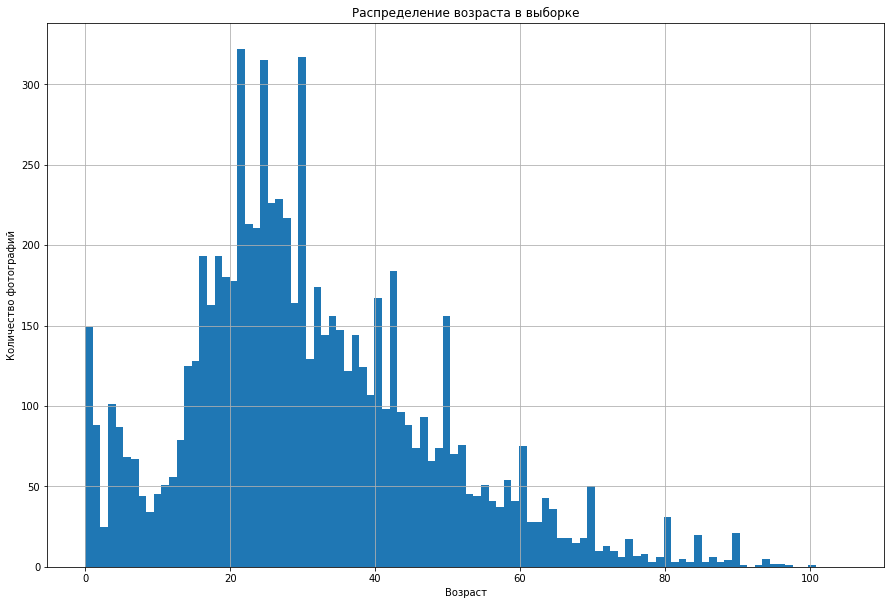

In [ ]:
labels.hist(bins=100, range=(0,105), figsize=(15, 10))
plt.title("Распределение возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество фотографий")
plt.grid(True)
plt.show()

Вывод на экран 15-ти изображений

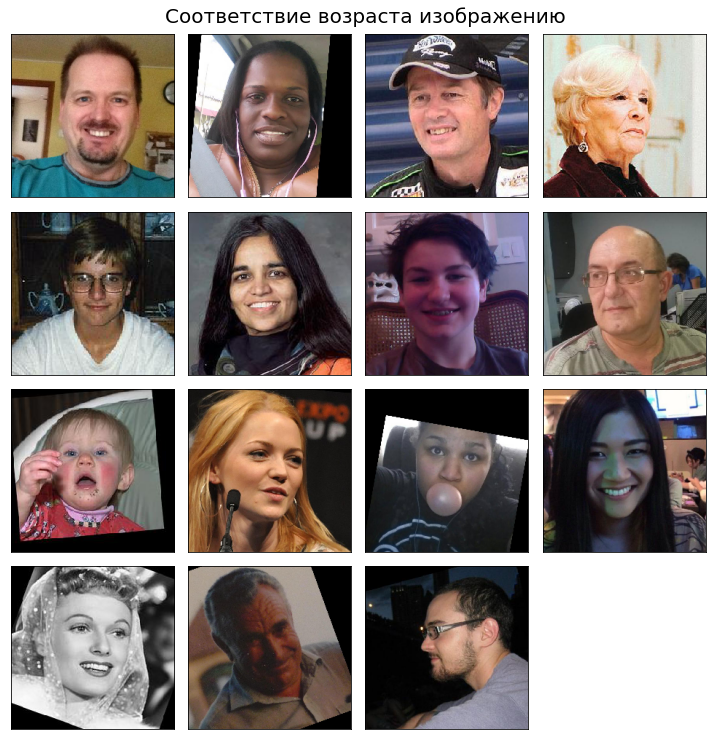

In [ ]:
features, target = next(train_gen_flow)


fig = plt.figure(figsize=(10,10))

for i in range(15):
    fig.add_subplot(4, 4, i+1)

    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    
plt.title('Соответствие возраста изображению', y=4.3, x=0, fontsize = 20)

plt.show()

**Выводы**
- в представленной выборке всего 7591 запись
- данные не разделены на классы
- пропущенных значений не обнаружено
- явных повторов не обнаружено
- медианное и среднее значения в выборке практически совпадают
- наиболее представленный диапазон возрастов: 20-40 лет
- в круглых датах возрастов наблюдаются пики, что вероятно свидетельствует о том, что настоящий возраст человека, изображённого на фото не известен и при формировании датасета было использовано округление
- общая ориентация фотографий вертикальная - повороты не требуются
- в наборе имеются как цветные, так и чёрно-белые фото
- встречаются фото разного размера

## Обучение модели

**Создание функции для загрузки обучающей выборки**

In [ ]:
def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=.2, rescale=1./255)
    
    df = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = (
        train_datagen.flow_from_dataframe(dataframe=df, directory=path + '/final_files', 
                                          x_col='file_name', y_col='real_age', target_size=(224, 224), 
                                          batch_size=32, class_mode='raw', seed=12345, subset='training')
        )
    
    return train_datagen_flow

**Создание функции для загрузки валидационной выборки**

In [ ]:
def load_test(path):

    test_datagen = ImageDataGenerator(validation_split=.2, rescale=1./255)
    
    df = pd.read_csv(path + 'labels.csv')
    
    test_datagen_flow = (
        test_datagen.flow_from_dataframe(dataframe=df, directory=path + '/final_files', 
                                         x_col='file_name', y_col='real_age', target_size=(224, 224), 
                                         batch_size=32, class_mode='raw', seed=12345, subset='validation')
        )
    
    return test_datagen_flow

**Функции для создания модели**

In [ ]:
def create_model(input_shape):

    model = Sequential()
    
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

    model = Sequential()

    model.add(backbone)
        
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

**Создание функции для обучения модели**

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=6, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2, shuffle=True)

    return model

**Процесс обучения модели и расчёт *MAE*:**

Found 6073 validated image filenames.

Found 1518 validated image filenames.


Train for 190 steps, validate for 48 steps

Epoch 1/6

2022-10-23 17:57:17.308471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-10-23 17:57:17.784449: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

190/190 - 66s - loss: 197.5205 - mean_absolute_error: 10.4228 - val_loss: 459.6240 - val_mean_absolute_error: 16.2294

Epoch 2/6

190/190 - 51s - loss: 99.7579 - mean_absolute_error: 7.6020 - val_loss: 342.2449 - val_mean_absolute_error: 13.7132

Epoch 3/6

190/190 - 43s - loss: 63.5036 - mean_absolute_error: 6.1160 - val_loss: 465.0636 - val_mean_absolute_error: 16.4212

Epoch 4/6

190/190 - 48s - loss: 44.8668 - mean_absolute_error: 5.1264 - val_loss: 176.1368 - val_mean_absolute_error: 9.9151

Epoch 5/6

190/190 - 51s - loss: 30.2485 - mean_absolute_error: 4.2542 - val_loss: 93.7815 - val_mean_absolute_error: 7.2176

Epoch 6/6

190/190 - 51s - loss: 20.9110 - mean_absolute_error: 3.5587 - val_loss: 75.7927 - val_mean_absolute_error: 6.5194


48/48 - 8s - loss: 75.7927 - mean_absolute_error: 6.5194

Test MAE: 6.5194

## Анализ обученной модели

Заключение по представленному датасету:
- в представленной выборке всего 7591 запись
- данные не разделены на классы
- пропущенных значений не обнаружено
- явных повторов не обнаружено
- медианное и среднее значения в выборке практически совпадают
- наиболее представленный диапазон возрастов: 20-40 лет
- в круглых датах возрастов наблюдаются пики, что вероятно свидетельствует о том, что настоящий возраст человека, изображённого на фото не известен и при формировании датасета было использовано округление
- общая ориентация фотографий вертикальная - повороты не требуются
- в наборе имеются как цветные, так и чёрно-белые фото
- встречаются фото разного размера

Для решения поставленной задачи использована предобученная на ImageNet сеть с архитектурой ResNet50 без верхушки.
<br>Для автоматизациии подбора шага применён алгоритм Adam.

- переобучения сети не наблюдается
- требуемый уровень качества предсказаний достигнут (**значение *MAE* на валидационной выборке = 6.5**)